In [1]:
!pip install -q scikit-learn matplotlib openml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from sklearn.metrics.pairwise import euclidean_distances

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.8/93.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.9 MB/s eta 0:00:00


In [2]:
# Load & Prepare Data
print("Downloading Fashion-MNIST from OpenML...")
fashion = fetch_openml(name="Fashion-MNIST", as_frame=False)
X = fashion.data / 255.0
y = fashion.target.astype(int)

labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

X_scaled = StandardScaler().fit_transform(X)
#subsample for speed
subset = 3000
X_sub, y_sub = X_scaled[:subset], y[:subset]

In [3]:
# Helper function for consistent legends
def add_label_legend(scatter, labels):
  handles = [mpatches.Patch(color = scatter.cmap(scatter.norm(i)), label = labels[i]) for i in range(len(labels))]
  plt.legend(handles = handles, bbox_to_anchor = (1.05, 1), loc = 'upper left')

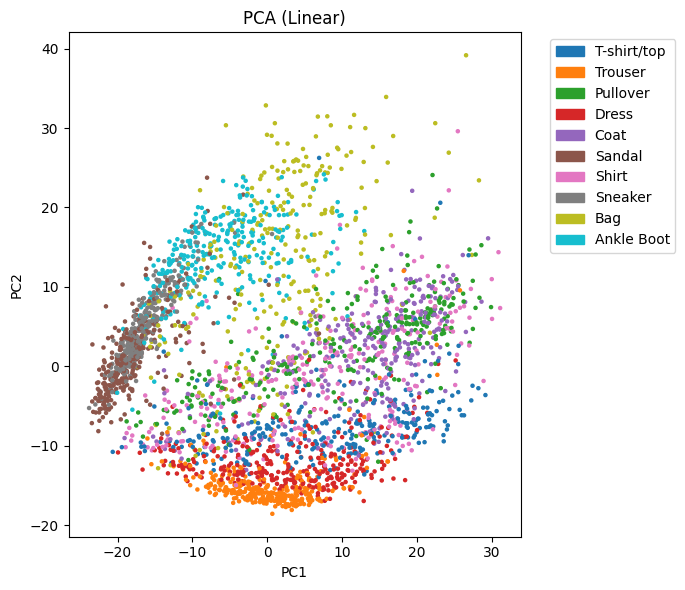

In [4]:
# PCA Linear Baseline
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_sub)
plt.figure(figsize = (7, 6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y_sub, cmap='tab10', s=5)
plt.title("PCA (Linear)")
plt.xlabel("PC1")
plt.ylabel("PC2")
add_label_legend(scatter, labels)
plt.tight_layout()
plt.show()

In [5]:
# PCA Loadings (Feature contributions)

loadings = pca.components_
print("Shape of loadings matrix:", loadings.shape)

# Display first few loadings of PC1
print("\nTop 10 loadings for PC1:")
for i, val in enumerate(loadings[0][:10]):
    print(f"Feature {i+1}: {val:.4f}")

# Variance explained by each component
explained_var = pca.explained_variance_ratio_
print(f"\nExplained variannce ratio: {explained_var[0]:.2%} (PC1), {explained_var[1]:.2%} (PC2)")

Shape of loadings matrix: (2, 784)

Top 10 loadings for PC1:
Feature 1: -0.0000
Feature 2: 0.0023
Feature 3: 0.0022
Feature 4: 0.0006
Feature 5: 0.0016
Feature 6: 0.0071
Feature 7: 0.0085
Feature 8: 0.0111
Feature 9: 0.0149
Feature 10: 0.0171

Explained variannce ratio: 21.89% (PC1), 14.58% (PC2)


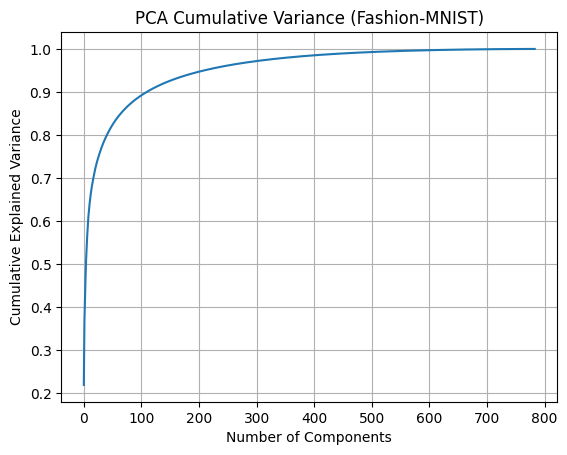

In [6]:
pca_full = PCA().fit(X_sub)
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Variance (Fashion-MNIST)')
plt.grid(True)
plt.show()

Using gamma = 0.000360


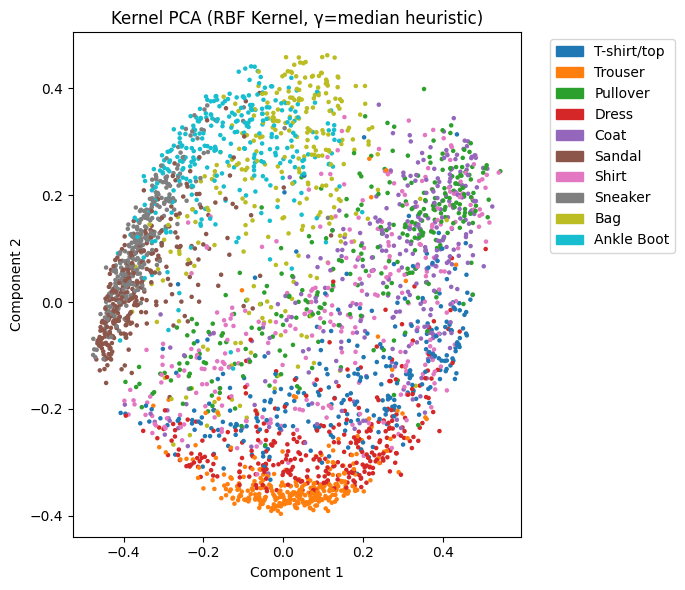

In [7]:
# Estimate gamma using the median heuristic
from sklearn.metrics.pairwise import euclidean_distances

dists = euclidean_distances(X_sub[:1000])
gamma = 1 / (2 * np.median(dists)**2)
print(f"Using gamma = {gamma:.6f}")

kpca = KernelPCA(n_components=2, kernel='rbf', gamma=gamma)
X_kpca = kpca.fit_transform(X_sub)

plt.figure(figsize=(7,6))
scatter = plt.scatter(X_kpca[:,0], X_kpca[:,1], c=y_sub, cmap='tab10', s=5)
plt.title("Kernel PCA (RBF Kernel, \u03b3=median heuristic)")
plt.xlabel("Component 1"); plt.ylabel("Component 2")
add_label_legend(scatter, labels)
plt.tight_layout()
plt.show()

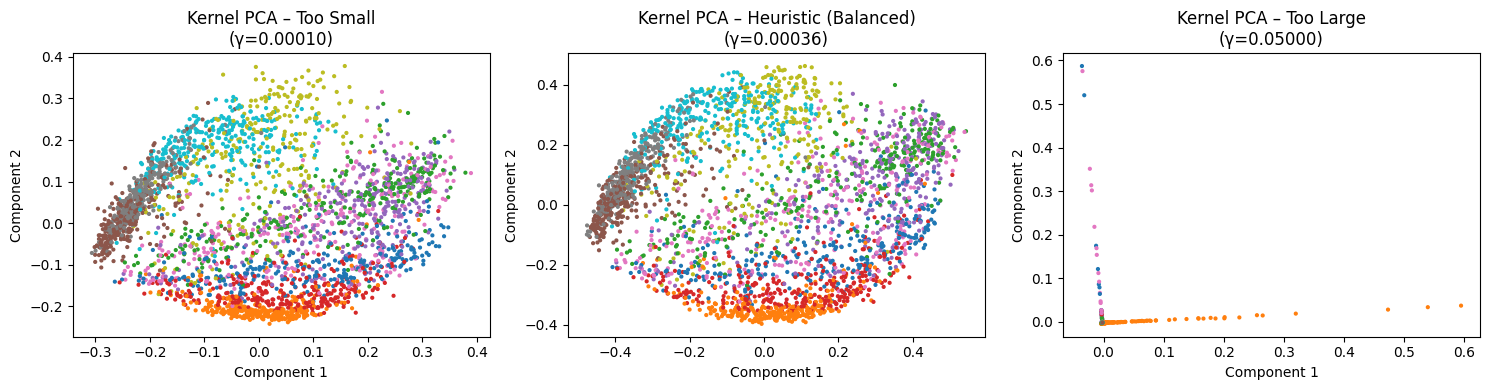

In [8]:
# Try several gamma values: too small, balanced, too large
gamma_values = [0.0001, gamma, 0.05] # reuse "gamma" from the median heuristic above
titles = ["Too Small", "Heuristic (Balanced)", "Too Large"]
plt.figure(figsize=(15, 4))
for i, (g, title) in enumerate(zip(gamma_values, titles)):
    kpca = KernelPCA(n_components=2, kernel='rbf', gamma=g)
    X_kpca = kpca.fit_transform(X_sub)
    plt.subplot(1, 3, i+1)
    scatter = plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=y_sub, cmap='tab10',s=4)
    plt.title(f"Kernel PCA – {title}\n(\u03b3={g:.5f})")
    plt.xlabel("Component 1"); plt.ylabel("Component 2")
plt.tight_layout()
plt.show()

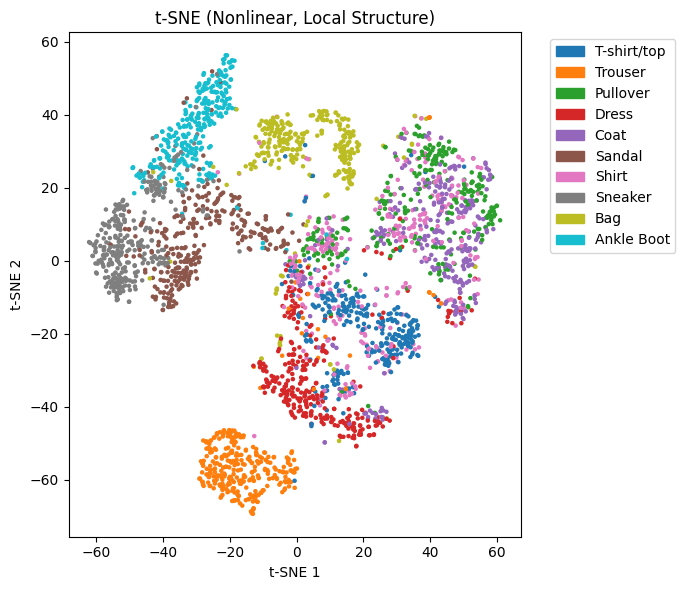

In [9]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_sub)
plt.figure(figsize=(7,6))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_sub, cmap='tab10', s=5)
plt.title("t-SNE (Nonlinear, Local Structure)")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
add_label_legend(scatter, labels)
plt.tight_layout()
plt.show()

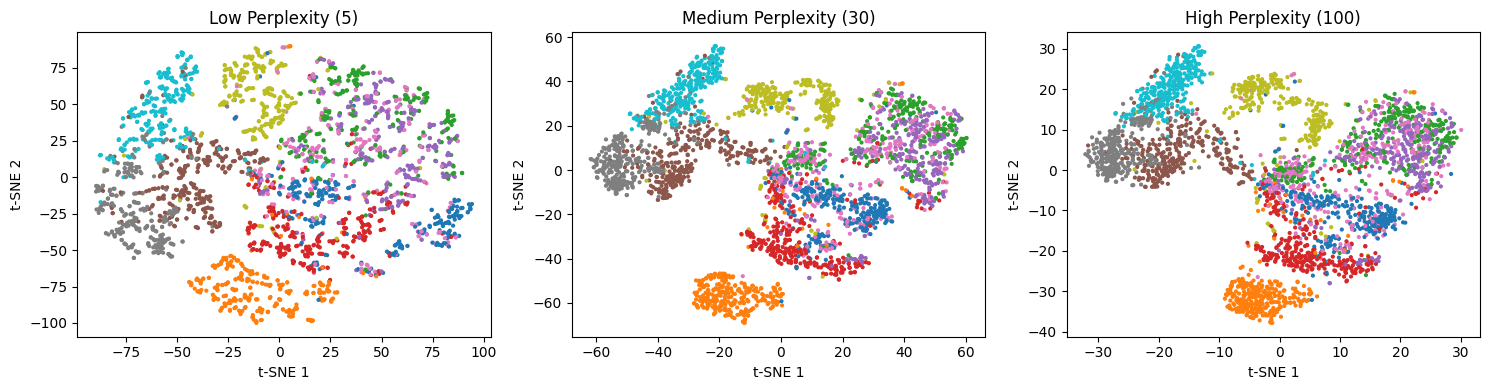

In [10]:
perplexities = [5, 30, 100] # low, medium (default), high
titles = ["Low Perplexity (5)", "Medium Perplexity (30)", "High Perplexity (100)"]
plt.figure(figsize=(15, 4))
for i, (p, title) in enumerate(zip(perplexities, titles)):
    tsne = TSNE(n_components=2, perplexity=p, learning_rate=200, random_state=7)
    X_tsne = tsne.fit_transform(X_sub)
    plt.subplot(1, 3, i + 1)
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sub, cmap="tab10", s=4)
    plt.title(f"{title}")
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()